The cavity main cavity mode ($\pi$) will be modeled coupled to the mechanical resonance of the system. This is given by the equations: 

This describes the voltage of the cavity. It's a second-order equation, but we're only concerned with slow oscillations, specifically 1 to 500 Hz. The driving terms ($ I_F$) of the cavities of interest are 325 MHz, 650 MHz, and 1.3 GHz. 

The equation is given by many []:

$
 \dot{V} + (\omega_{1/2}-i \Delta \omega)V = 2\omega_{1/2} R_L I_F
$

The equation for the mechanical modes is given by [] : 

$
    \ddot{\Delta \omega_m } + 2/\tau_m \dot{\Delta \omega_m} + \Omega_m^2 \Delta \omega_m = k_m^{LFD}*E_{acc}^2 
$

The driving term is just from Lorentz force. No piezo control is added. The total detuning is then 

$
    \Delta \omega =\sum_m  \Delta \omega_m 
$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Time of the simulation 
tmax = 0.5  # Max time in seconds
dt = 1e-6   # Time step in seconds, a larger value will lead to numerical instability. ONLY USE VALUES SMALLER THAN THIS.

t = np.arange(0, tmax, dt)  # Time vector
L = len(t)
w = 2 * np.pi * np.fft.fftfreq(L, dt)  # Frequency vector for FFT

In [3]:
# Cavity parameters (650 MHz, low beta)
#Coupling parameter of the cavity 
Qext = 3e6
Q0 = 2.7e10
beta = Q0 / Qext
QL = Q0 / (1 + beta)
#Cavity frequency
w0 = 2 * np.pi * 650e6  # Units in Hz
rQ=341 # r/Q cavity
RL = (0.5 * 341) * QL  # loaded r/Q of cavity, units in Ohm
#half bandwidth of the cavity 
whalf = w0 / (2 * QL)

#effective length of acceleration 
Leff = 1.038  # Units in Meters
#Time constant of the cavity, determines filling time and decay
tau = 2 * QL / w0  # Units in seconds

#parameters used to determine the fill time of the cavity, used for forward. 
t1 = 1e-3
tfill = t1 + tau * np.log(2)
tflat = tfill + t1

#beam time parameters 
t_b = tfill + 0.15e-3
t_bf = tfill + 0.9e-3

#Ratio to produce flat top where the beam is accelerated. 
ratio = (1 - np.exp(-(tfill - t1) / tau))

# amplitude constant
Amp = (25e6 * Leff) / RL  # units A

#The driving term, a square pulse, needs to be adjusted 
forward = Amp * ( (t >= t1) * (t < tfill) + ratio * (t >= tfill) * (t < tflat) )

#beam term, not yet implemented.
i_beam = 0 * 2e-3 * ( (t >= t_b) * (t < t_bf) ) #The effects of the beam are not considered yet 


In [4]:
#Starting the variables
V = np.zeros(L, dtype=np.complex128) # Cavity voltage
DW_m = np.zeros((L, 10)) #mechanical mode of the cavity m, measured in Hz. 10 mechanical modes are simulated
DW = np.zeros(L)         #Total cavity detuning, sum of all the modes. 
wdot = np.zeros((L, 10)) #Time derivative of the detuning
Eacc = np.zeros(L)       #Accelerating gradient of the cavity 

In [6]:
# Frequency of the mechanical modes. 
O_m = 2 * np.pi * np.array([157, 182, 189, 215, 292, 331, 380, 412, 462, 471]) # units inside the array are in Hz
O_m_squared = O_m**2
# These numbers are not realistic; other data exist for this and will later be
# Lorentz force detuning, coupling to the voltage,  
k_p =2*np.pi*3.5 * np.array([0.02, 0.03, 0.055, 0.55, 0.085, 0.029, 0.052, 0.19, 0.075, 0.095]) #needs to be better normalized, unites are in Hz/(MV/m)^2  

#time constant of the mechanical modes 
tau_m = 2 * np.array([56.8, 113.2, 70.38, 25, 150, 304.2, 409.46, 305.11, 202.19, 205.86]) * 1e-3 # units of s
#Coupling term between the Voltage and DW 
G = k_p * O_m_squared*0 # This shows the effect of no detuning, it's set to 0 

In [7]:
#Solved coupled equations, use the Euler method.
for k in range(L - 1):
    # First-order ODE for cavity voltage (V)
    f1 = (-whalf + DW[k] * 1j) * V[k] + 2 * RL * whalf * (forward[k] - i_beam[k] / 2)
    V[k+1] = V[k] + dt * f1 # unit of V
    Eacc[k] = np.abs(V[k] / 1e6) / Leff # units of MV/m
    
    # Second-order ODE for mechanical modes (Detuning)
    DW_m[k+1, :] = DW_m[k, :] + dt * wdot[k, :]
    f4 = -G * (Eacc[k])**2 - (2 / tau_m) * wdot[k, :] - O_m_squared * DW_m[k, :]
    wdot[k+1, :] = wdot[k, :] + dt * f4
    DW[k+1] = np.sum(DW_m[k+1, :]) #units in Hz, angular frequency

The following shows the results with no Lorentz force detuning on the cavity. 

<Figure size 640x480 with 0 Axes>

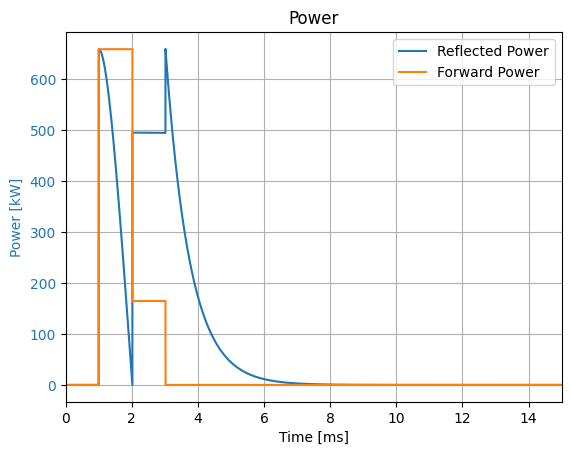

In [8]:
Pfor = RL / 2 * forward**2
P_R = Pfor - np.abs(V)**2 / (2 * RL)

# Plot Power and Beam Current
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(t * 1000, np.abs(P_R) / 1e3, color='tab:blue', label='Reflected Power')
ax1.plot(t * 1000, Pfor / 1e3, color='tab:orange', label='Forward Power')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Power [kW]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='best')

plt.xlim([0, 15])
plt.title('Power')
plt.grid(True)
plt.show()


<Figure size 640x480 with 0 Axes>

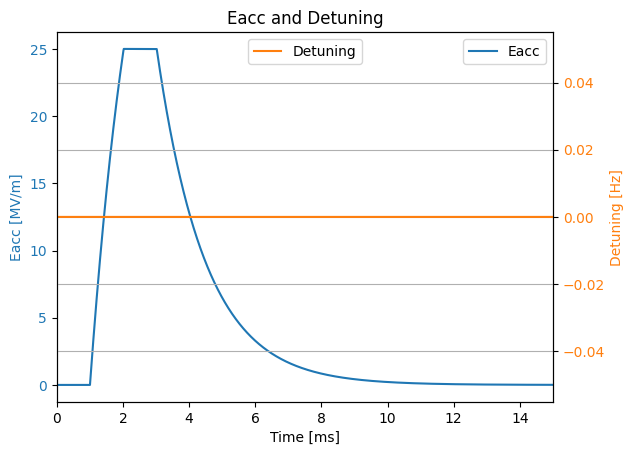

In [9]:
# Plot Eacc and Detuning
plt.figure(2)
fig, ax1 = plt.subplots()
ax1.plot(t * 1000, Eacc, color='tab:blue', label='Eacc')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Eacc [MV/m]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='best')

ax2 = ax1.twinx()
ax2.plot(t * 1000, DW/(2*np.pi), color='tab:orange', label='Detuning')
ax2.set_ylabel('Detuning [Hz]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper center')
plt.xlim([0, 15])
plt.title('Eacc and Detuning')
plt.grid(True)
plt.show()

The flat region in the Eacc is where the beam should be accelerated. Any small deviation from the value will lead to beam degradation. In this case 0 Hz detuning is the best case. 

This is then again calculated turning on the lorentz force detuning of experience by the cavity.

In [10]:
#Coupling term between the Voltage and DW 
G = k_p * O_m_squared 

#Solved coupled equations, use the Euler method.
for k in range(L - 1):
    # First-order ODE for cavity voltage (V)
    f1 = (-whalf + DW[k] * 1j) * V[k] + 2 * RL * whalf * (forward[k] - i_beam[k] / 2)
    V[k+1] = V[k] + dt * f1 # unit of V
    Eacc[k] = np.abs(V[k] / 1e6) / Leff # units of MV/m
    
    # Second-order ODE for mechanical modes (Detuning)
    DW_m[k+1, :] = DW_m[k, :] + dt * wdot[k, :]
    f4 = -G * (Eacc[k])**2 - (2 / tau_m) * wdot[k, :] - O_m_squared * DW_m[k, :]
    wdot[k+1, :] = wdot[k, :] + dt * f4
    DW[k+1] = np.sum(DW_m[k+1, :]) #units in Hz, angular frequency

<Figure size 640x480 with 0 Axes>

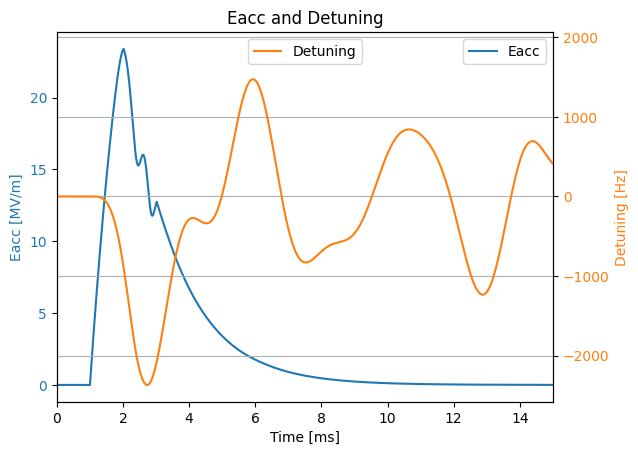

In [11]:
# Plot Eacc and Detuning
plt.figure(2)
fig, ax1 = plt.subplots()
ax1.plot(t * 1000, Eacc, color='tab:blue', label='Eacc')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Eacc [MV/m]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='best')

ax2 = ax1.twinx()
ax2.plot(t * 1000, DW/(2*np.pi), color='tab:orange', label='Detuning')
ax2.set_ylabel('Detuning [Hz]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper center')
plt.xlim([0, 15])
plt.title('Eacc and Detuning')
plt.grid(True)
plt.show()

Note now that the Eacc is no longer flat and drops. This is caused by the shift in the cavity detuning. The time component of the detuning shows the main mechanical modes of the cavity. 

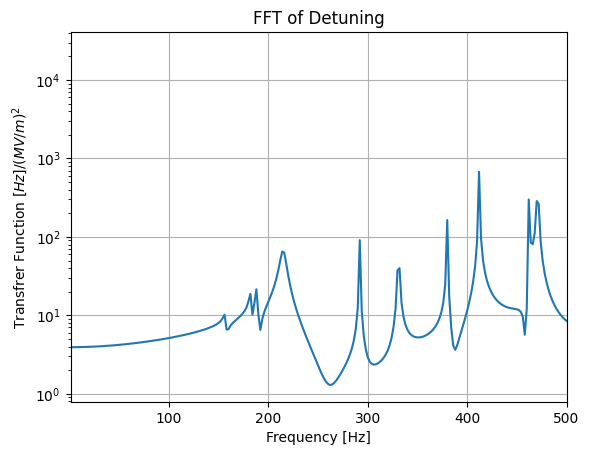

In [16]:
# Plot the FFT of the detuning signal
plt.figure(3)
# Subtract the mean to remove the DC component before FFT
f_centered = (DW - np.mean(DW))/(2*np.pi)
fft_f = np.fft.fft(f_centered)
fft_Eacc= np.fft.fft(Eacc**2)
freqs = np.fft.fftfreq(len(f_centered), dt)
# Plot only the positive frequencies
positive_freqs_mask = freqs > 0
plt.semilogy(freqs[positive_freqs_mask], np.abs(fft_f[positive_freqs_mask]/fft_Eacc[positive_freqs_mask] ))
plt.xlim([1, 500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Transfrer Function $[Hz]/(MV/m)^2$')
plt.title('FFT of Detuning')
plt.grid(True)
plt.show()

This is the FFT of the cavity mechanical modes. The piezo, which is used to control, is modeled in the same fashion as the LFD. A coupling term is needed and each mode is mode has a certain sensitivity. 